In [18]:
import shutil
import os

# Replace 'your_folder_path' with the path to the directory you want to delete
folder_path = '/content/cell_images/positive'

# Check if the folder exists
if os.path.exists(folder_path):
    # Remove the folder
    shutil.rmtree(folder_path)
    print(f"Folder '{folder_path}' has been deleted.")
else:
    print(f"Folder '{folder_path}' does not exist.")


Folder '/content/cell_images/positive' has been deleted.


In [19]:
import os
from pathlib import Path
from zipfile import ZipFile

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [16]:
# Extract dataset zip file
file_name = '/content/cell_images.zip'
with ZipFile(file_name, 'r') as zip:
    zip.extractall()

In [20]:
import os

folder_path = '/content/cell_images'  # Replace with your folder path

image_files = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            image_files.append(os.path.join(root, file))

number_of_images = len(image_files)

print(f"Number of image files in the folder: {number_of_images}")


Number of image files in the folder: 27558


In [21]:
data_dir = '/content/cell_images' # Use the path for extracted the data

# Define the original and new directory names
original_dirs = {
    'Uninfected': 'positive',
    'Parasitized': 'negative'
}

# Renaming directories
for original_dir, new_dir in original_dirs.items():
    original_path = os.path.join(data_dir, original_dir)
    new_path = os.path.join(data_dir, new_dir)

    # Check if the new directory name already exists. If it does, consider deleting it or moving it.
    if os.path.exists(new_path):
        print(f"The directory {new_path} already exists. Consider deleting or moving it before renaming.")

    # Now, rename the original directory to the new directory name
    if os.path.exists(original_path):
        os.rename(original_path, new_path)
        print(f"Renamed {original_path} to {new_path}")
    else:
        print(f"The directory {original_path} does not exist. Skipping.")

Renamed /content/cell_images/Uninfected to /content/cell_images/positive
Renamed /content/cell_images/Parasitized to /content/cell_images/negative


In [22]:
# Define the main data directory
data_dir = '/content/cell_images'  # Replace with the path to your dataset

# Define training and validation directory paths
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

# Create training and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Now use the split_dataset function
split_dataset(data_dir, train_dir, val_dir, train_size=0.8)


In [ ]:
# from sklearn.model_selection import train_test_split
# import shutil

# def split_dataset(data_dir, train_dir, val_dir, train_size=0.8):
#     classes = ['positive', 'negative']  # As per your renaming
#     for cls in classes:
#         full_cls_path = os.path.join(data_dir, cls)
#         train_cls_path = os.path.join(train_dir, cls)
#         val_cls_path = os.path.join(val_dir, cls)

#         if not os.path.exists(train_cls_path):
#             os.makedirs(train_cls_path)
#         if not os.path.exists(val_cls_path):
#             os.makedirs(val_cls_path)

#         images = os.listdir(full_cls_path)
#         train_files, val_files = train_test_split(images, train_size=train_size, random_state=42)

#         for img in train_files:
#             shutil.move(os.path.join(full_cls_path, img), os.path.join(train_cls_path, img))
#         for img in val_files:
#             shutil.move(os.path.join(full_cls_path, img), os.path.join(val_cls_path, img))

# # Usage
# split_dataset(data_dir, train_dir, val_dir)


In [30]:
###             ###



data_dir = '/content/cell_images'  # Update this path
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'
IMG_SIZE = (180, 180)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)


Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [31]:
resnet_model = Sequential()


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,),pooling='avg',classes='2')
for layer in base_model.layers:

  layer.trainable = False  # Freeze the base model


resnet_model = Sequential()
resnet_model.add(base_model)

resnet_model.add(Dense(1024, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
resnet_model.add(Dense(2, activation='softmax'))



In [32]:
resnet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_5 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 25687938 (97.99 MB)
Trainable params: 2100226 (8.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [33]:
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
history = resnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator)


Epoch 1/10
689/689 [==============================] - 66s 95ms/step - loss: 0.6069 - accuracy: 0.6722 - val_loss: 0.6072 - val_accuracy: 0.6671
Epoch 2/10
689/689 [==============================] - 65s 95ms/step - loss: 0.6142 - accuracy: 0.6635 - val_loss: 0.5855 - val_accuracy: 0.6909
Epoch 3/10
689/689 [==============================] - 65s 95ms/step - loss: 0.6025 - accuracy: 0.6765 - val_loss: 0.5893 - val_accuracy: 0.6912
Epoch 4/10
689/689 [==============================] - 65s 95ms/step - loss: 0.6044 - accuracy: 0.6760 - val_loss: 0.6142 - val_accuracy: 0.6526
Epoch 5/10
689/689 [==============================] - 65s 95ms/step - loss: 0.6017 - accuracy: 0.6771 - val_loss: 0.5815 - val_accuracy: 0.6918
Epoch 6/10
689/689 [==============================] - 65s 95ms/step - loss: 0.6015 - accuracy: 0.6751 - val_loss: 0.6046 - val_accuracy: 0.6658
Epoch 7/10
689/689 [==============================] - 65s 95ms/step - loss: 0.5982 - accuracy: 0.6803 - val_loss: 0.5850 - val_accuracy:

173/173 [==============================] - 12s 71ms/step - loss: 0.5663 - accuracy: 0.7110
Validation Accuracy: 0.71%
173/173 [==============================] - 13s 69ms/step


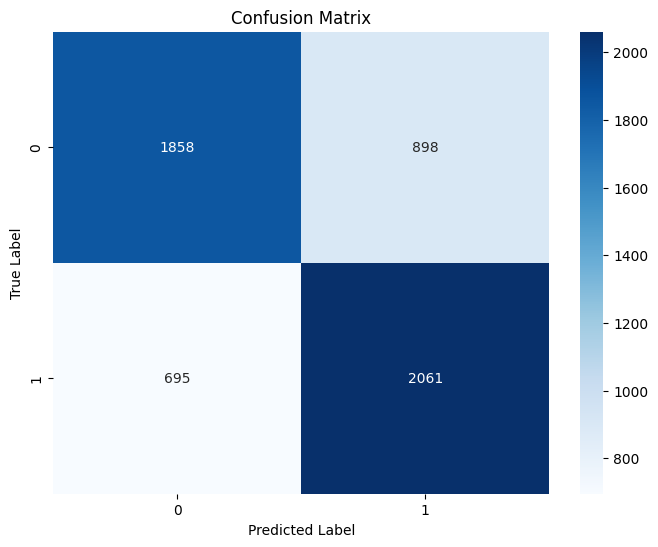

In [38]:
# Evaluate the model
val_loss, val_accuracy = resnet_model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}%")

# Generate predictions
y_pred = resnet_model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Retrieve the actual labels
y_true = val_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


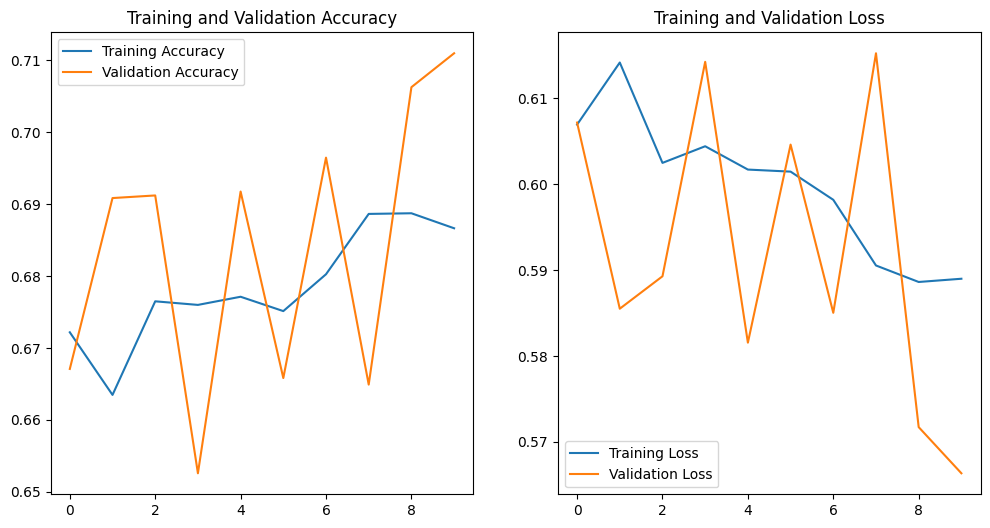

In [39]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
